# Flirt Detection Model - Training, Validation, and Testing

This notebook covers the complete pipeline for training, validating, and testing the DistilBERT-based flirt detection model.

## Overview
- **Model**: DistilBERT with custom classification head
- **Task**: Binary classification (Flirt vs Non-Flirt)
- **Dataset**: Processed detection data (train/val/test splits)
- **Goal**: Achieve >80% accuracy


## 1. Setup and Imports


In [10]:
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm

# Import transformers AFTER fixing dependencies
try:
    from transformers import get_linear_schedule_with_warmup
    print("✓ Transformers imported successfully")
except ImportError as e:
    print(f"❌ Error importing transformers: {e}")
    print("Please run the dependency fix cell first and restart runtime")
    raise

# Scikit-learn for metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Add src to path - resolve detection module location
current_dir = Path(os.getcwd())
src_path = None

# Try to find src/detection directory
candidates = [
    current_dir / 'src',  # If notebook is in flirt-detection/
    current_dir.parent / 'flirt-detection' / 'src',  # If running from project root
    Path(__file__).parent / 'src' if '__file__' in globals() else None,  # If running as script
]

for candidate in candidates:
    if candidate and (candidate / 'detection' / 'model.py').exists():
        src_path = candidate.resolve()
        break

if src_path is None:
    # Fallback: use current_dir/src
    src_path = (current_dir / 'src').resolve()

# Add to Python path
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Add /content/ to sys.path explicitly for model.py import if it's there
if '/content/' not in sys.path and os.path.exists('/content/model.py'):
    sys.path.insert(0, '/content/')

# Set project root for data paths
project_root = src_path.parent.parent if 'flirt-detection' in str(src_path) else src_path.parent

# Import model with better error handling
try:
    from model import FlirtDetectionModel, FlirtDetectionTokenizer, count_parameters
    print("✓ Model imported successfully")
except ImportError as e:
    print(f"❌ Error importing model: {e}")
    print(f"Current sys.path: {sys.path}")
    print(f"Looking for model.py in: {src_path}")
    raise

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n{'='*50}")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
print(f"{'='*50}\n")

✓ Transformers imported successfully
✓ Model imported successfully

Using device: cuda
PyTorch version: 2.9.1+cu128
GPU: Tesla T4
CUDA version: 12.8



## 2. Load and Explore Data


In [11]:
from pathlib import Path

# Load data from CSV files
data_dir = Path('drive') / 'MyDrive' / 'data' / 'processed'

train_df = pd.read_csv(data_dir / 'detection_train.csv')
val_df = pd.read_csv(data_dir / 'detection_val.csv')
test_df = pd.read_csv(data_dir / 'detection_test.csv')

# Display dataset sizes
print("="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"Total samples: {len(train_df) + len(val_df) + len(test_df):,}")
print("="*60)

# Label distributions
print("\nTraining label distribution:")
train_dist = train_df['label'].value_counts().sort_index()
print(train_dist)
print(f"Class balance: {train_dist[0]/(train_dist[0]+train_dist[1]):.2%} / {train_dist[1]/(train_dist[0]+train_dist[1]):.2%}")

print("\nValidation label distribution:")
val_dist = val_df['label'].value_counts().sort_index()
print(val_dist)
print(f"Class balance: {val_dist[0]/(val_dist[0]+val_dist[1]):.2%} / {val_dist[1]/(val_dist[0]+val_dist[1]):.2%}")

print("\nTest label distribution:")
test_dist = test_df['label'].value_counts().sort_index()
print(test_dist)
print(f"Class balance: {test_dist[0]/(test_dist[0]+test_dist[1]):.2%} / {test_dist[1]/(test_dist[0]+test_dist[1]):.2%}")

DATASET SUMMARY
Training samples: 2,599
Validation samples: 557
Test samples: 558
Total samples: 3,714

Training label distribution:
label
0.0    1299
1.0    1300
Name: count, dtype: int64
Class balance: 49.98% / 50.02%

Validation label distribution:
label
0.0    279
1.0    278
Name: count, dtype: int64
Class balance: 50.09% / 49.91%

Test label distribution:
label
0.0    279
1.0    279
Name: count, dtype: int64
Class balance: 50.00% / 50.00%


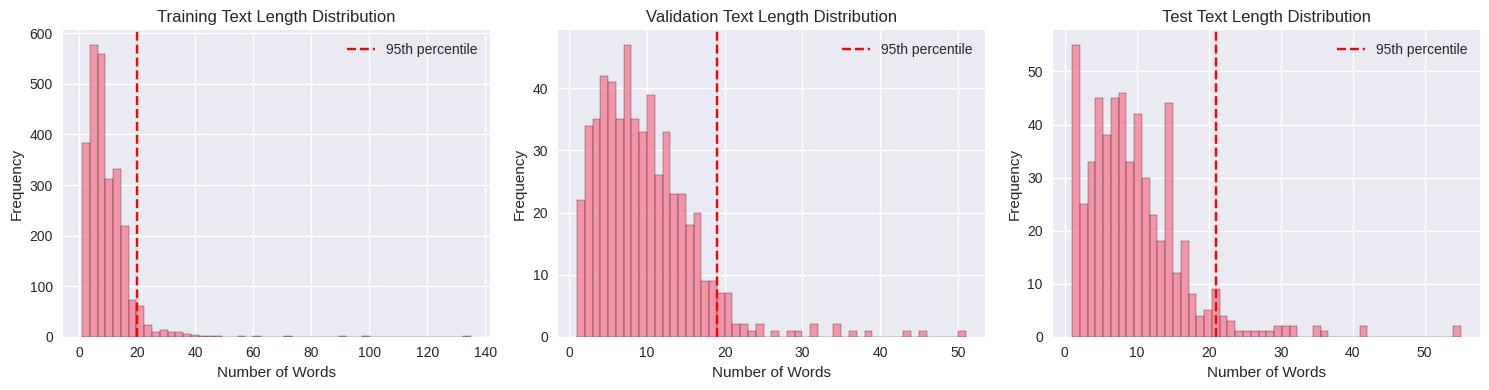

Training - Mean: 9.5, Median: 8.0, 95th percentile: 20.0
Validation - Mean: 9.2, Median: 8.0, 95th percentile: 19.0
Test - Mean: 9.7, Median: 8.0, 95th percentile: 21.0

Sample training texts:
Not Flirt: i’m chillin just stuck at home like everyone else lol. v boring
Flirt: i walked by today and remembered the last time we were there
Flirt: 😜
Flirt: so how have u been?
Flirt: omg you better be jerking off.


In [12]:
# Explore text lengths
train_lengths = [len(text.split()) for text in train_df['text']]
val_lengths = [len(text.split()) for text in val_df['text']]
test_lengths = [len(text.split()) for text in test_df['text']]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(train_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Training Text Length Distribution')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.percentile(train_lengths, 95), color='r', linestyle='--', label='95th percentile')
axes[0].legend()

axes[1].hist(val_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_title('Validation Text Length Distribution')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.percentile(val_lengths, 95), color='r', linestyle='--', label='95th percentile')
axes[1].legend()

axes[2].hist(test_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[2].set_title('Test Text Length Distribution')
axes[2].set_xlabel('Number of Words')
axes[2].set_ylabel('Frequency')
axes[2].axvline(np.percentile(test_lengths, 95), color='r', linestyle='--', label='95th percentile')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"Training - Mean: {np.mean(train_lengths):.1f}, Median: {np.median(train_lengths):.1f}, 95th percentile: {np.percentile(train_lengths, 95):.1f}")
print(f"Validation - Mean: {np.mean(val_lengths):.1f}, Median: {np.median(val_lengths):.1f}, 95th percentile: {np.percentile(val_lengths, 95):.1f}")
print(f"Test - Mean: {np.mean(test_lengths):.1f}, Median: {np.median(test_lengths):.1f}, 95th percentile: {np.percentile(test_lengths, 95):.1f}")

# Sample data
print("\nSample training texts:")
for i in range(5):
    label_str = "Flirt" if train_df.iloc[i]['label'] == 1.0 else "Not Flirt"
    print(f"{label_str}: {train_df.iloc[i]['text']}")


## 3. Create Dataset and DataLoaders


In [13]:
class FlirtDataset(Dataset):
    """Dataset class for flirt detection"""

    def __init__(self, texts: List[str], labels: List[int], tokenizer: FlirtDetectionTokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        # Tokenize
        encoding = self.tokenizer.encode_single(text)

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer
MAX_LENGTH = 128  # Based on text length analysis
tokenizer = FlirtDetectionTokenizer(max_length=MAX_LENGTH)

# Create datasets
train_texts = train_df['text'].tolist()
train_labels = train_df['label'].astype(int).tolist()

val_texts = val_df['text'].tolist()
val_labels = val_df['label'].astype(int).tolist()

test_texts = test_df['text'].tolist()
test_labels = test_df['label'].astype(int).tolist()

train_dataset = FlirtDataset(train_texts, train_labels, tokenizer)
val_dataset = FlirtDataset(val_texts, val_labels, tokenizer)
test_dataset = FlirtDataset(test_texts, test_labels, tokenizer)

# Create data loaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Train batches: 163
Val batches: 35
Test batches: 35


## 5. Training Functions


In [14]:
def train_epoch(model, dataloader, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        preds = torch.argmax(outputs['logits'], dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy


def validate(model, dataloader, device):
    """Validate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validation")
        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']

            # Statistics
            total_loss += loss.item()
            preds = torch.argmax(outputs['logits'], dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1, all_preds, all_labels


## 6. Training Loop


In [24]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from datasets import Dataset
import torch
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC

# ============================================================
# MODEL CONFIGURATIONS
# ============================================================
TRANSFORMER_MODELS = {
    "cardiffnlp/twitter-roberta-base-sentiment-latest": {
        "learning_rate": 1e-5,
        "num_train_epochs": 5,
        "weight_decay": 0.01,
        "warmup_ratio": 0.1,
        "batch_size": 16
    },
    "microsoft/deberta-v3-base": {
        "learning_rate": 1e-5,
        "num_train_epochs": 4,
        "weight_decay": 0.01,
        "warmup_ratio": 0.1,
        "batch_size": 8
    },
    "roberta-base": {
        "learning_rate": 2e-5,
        "num_train_epochs": 4,
        "weight_decay": 0.01,
        "warmup_ratio": 0.06,
        "batch_size": 16
    }
}

TRADITIONAL_MODELS = {
    "LogisticRegression": LogisticRegression(max_iter=1000, C=1.0, random_state=42),
    "LinearSVC": LinearSVC(C=1.0, random_state=42, max_iter=2000, dual='auto'),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42, learning_rate=0.1)
}

print("Dataset sizes:")
print(f"  Train: {len(train_df)} samples")
print(f"  Val:   {len(val_df)} samples")
print(f"  Test:  {len(test_df)} samples\n")

# Create models directory
os.makedirs("saved_models", exist_ok=True)

# ============================================================
# TRADITIONAL ML
# ============================================================
def train_traditional_models(results_list, trained_models):
    print(f"\n{'='*70}")
    print(f"TRADITIONAL ML MODELS (TF-IDF)")
    print(f"{'='*70}\n")

    X_train, y_train = train_df['text'], train_df['label']
    X_test, y_test = test_df['text'], test_df['label']

    print("Creating TF-IDF vectors...")
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    print(f"✓ Train: {X_train_vec.shape}, Test: {X_test_vec.shape}\n")

    for model_name, model in TRADITIONAL_MODELS.items():
        print(f"Training {model_name}...", end=" ")
        try:
            model.fit(X_train_vec, y_train)
            y_pred = model.predict(X_test_vec)

            acc = accuracy_score(y_test, y_pred)

            results_list.append({
                "model_type": "Traditional ML",
                "model": model_name,
                "accuracy": acc,
                "f1_weighted": f1_score(y_test, y_pred, average='weighted', zero_division=0),
                "f1_macro": f1_score(y_test, y_pred, average='macro', zero_division=0),
                "precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
                "recall": recall_score(y_test, y_pred, average='weighted', zero_division=0)
            })

            # Store model and vectorizer for potential saving
            trained_models[model_name] = {
                'model': model,
                'vectorizer': vectorizer,
                'accuracy': acc
            }

            print(f"✓ Test Acc: {acc:.4f}")
        except Exception as e:
            print(f"✗ Error: {str(e)}")

# ============================================================
# TRANSFORMERS
# ============================================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted", zero_division=0),
        "precision": precision_score(labels, preds, average="weighted", zero_division=0),
        "recall": recall_score(labels, preds, average="weighted", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0)
    }

def prepare_dataset_for_training(df, tokenizer, max_length=128):
    """Prepare dataset with int64 labels"""
    dataset_dict = {
        'text': df['text'].tolist(),
        'labels': df['label'].astype(np.int64).tolist()
    }
    dataset = Dataset.from_dict(dataset_dict)

    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            padding='max_length',
            max_length=max_length
        )

    tokenized = dataset.map(tokenize_function, batched=True)
    tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

    return tokenized

def train_transformer_models(results_list, trained_models):
    print(f"\n{'='*70}")
    print(f"TRANSFORMER MODELS (Deep Learning)")
    print(f"{'='*70}\n")

    for model_name, config in TRANSFORMER_MODELS.items():
        print(f"Training {model_name}...")

        try:
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            model = AutoModelForSequenceClassification.from_pretrained(
                model_name,
                num_labels=2,
                ignore_mismatched_sizes=True
            )

            train_encoded = prepare_dataset_for_training(train_df, tokenizer)
            val_encoded = prepare_dataset_for_training(val_df, tokenizer)
            test_encoded = prepare_dataset_for_training(test_df, tokenizer)

            output_dir = f"results/{model_name.replace('/', '_')}"
            args = TrainingArguments(
                output_dir=output_dir,
                learning_rate=config['learning_rate'],
                num_train_epochs=config['num_train_epochs'],
                per_device_train_batch_size=config['batch_size'],
                per_device_eval_batch_size=config['batch_size'],
                weight_decay=config['weight_decay'],
                warmup_ratio=config['warmup_ratio'],
                eval_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="f1",
                logging_steps=50,
                fp16=torch.cuda.is_available(),
                report_to="none",
                seed=42,
                logging_first_step=False
            )

            trainer = Trainer(
                model=model,
                args=args,
                train_dataset=train_encoded,
                eval_dataset=val_encoded,
                tokenizer=tokenizer,
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
            )

            trainer.train()
            test_metrics = trainer.predict(test_encoded)

            acc = test_metrics.metrics['test_accuracy']

            results_list.append({
                "model_type": "Transformer",
                "model": model_name,
                "accuracy": acc,
                "f1_weighted": test_metrics.metrics['test_f1'],
                "f1_macro": test_metrics.metrics['test_f1_macro'],
                "precision": test_metrics.metrics['test_precision'],
                "recall": test_metrics.metrics['test_recall']
            })

            # Store model and tokenizer for potential saving
            trained_models[model_name] = {
                'model': model,
                'tokenizer': tokenizer,
                'accuracy': acc
            }

            print(f"✓ Test Acc: {acc:.4f}, F1: {test_metrics.metrics['test_f1']:.4f}\n")

            # Don't delete yet - we might need to save it
            # del model, trainer
            # torch.cuda.empty_cache() if torch.cuda.is_available() else None

        except Exception as e:
            print(f"✗ Error: {str(e)}")
            import traceback
            traceback.print_exc()

# ============================================================
# RUN EXPERIMENTS
# ============================================================
results = []
trained_models = {}  # Store all trained models
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"{'='*70}")
print(f"DEVICE: {device}")
print(f"MODELS: 6 total (3 Traditional ML + 3 Transformers)")
print(f"{'='*70}\n")

train_traditional_models(results, trained_models)
train_transformer_models(results, trained_models)

# ============================================================
# RESULTS & SAVE BEST MODEL
# ============================================================
print(f"\n{'='*70}")
print("FINAL TEST SET RESULTS")
print(f"{'='*70}\n")

df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values(by="accuracy", ascending=False)

print("ALL MODELS (sorted by test accuracy):")
print(df_sorted[['model_type', 'model', 'accuracy', 'f1_weighted']].to_string(index=False))

if 'Transformer' in df_results['model_type'].values:
    print(f"\n{'='*70}")
    print("TRADITIONAL ML vs TRANSFORMERS")
    print(f"{'='*70}")
    comparison = df_results.groupby('model_type').agg({
        'accuracy': ['mean', 'std', 'max'],
        'f1_weighted': ['mean', 'std', 'max']
    }).round(4)
    print(comparison)

print(f"\n{'='*70}")
print("🏆 BEST OVERALL MODEL")
print(f"{'='*70}")
best = df_sorted.iloc[0]
best_model_name = best['model']
best_model_type = best['model_type']

print(f"Type: {best_model_type}")
print(f"Model: {best_model_name}")
print(f"Test Accuracy: {best['accuracy']:.4f}")
print(f"Test F1: {best['f1_weighted']:.4f}")
print(f"Improvement over baseline (78.67%): {(best['accuracy'] - 0.7867) * 100:+.2f}%")

# ============================================================
# SAVE BEST MODEL
# ============================================================
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print(f"\n{'='*70}")
print("SAVING BEST MODEL")
print(f"{'='*70}")

if best_model_name in trained_models:
    if best_model_type == "Transformer":
        # Save transformer model
        model_save_path = f"saved_models/best_model_{timestamp}.pt"
        tokenizer_save_path = f"saved_models/best_tokenizer_{timestamp}"
        config_save_path = f"saved_models/best_model_config_{timestamp}.json"

        # Save model state dict
        torch.save({
            'model_state_dict': trained_models[best_model_name]['model'].state_dict(),
            'model_name': best_model_name,
            'accuracy': best['accuracy'],
            'f1_weighted': best['f1_weighted'],
            'timestamp': timestamp
        }, model_save_path)

        # Save tokenizer
        trained_models[best_model_name]['tokenizer'].save_pretrained(tokenizer_save_path)

        # Save config
        import json
        config = {
            'model_name': best_model_name,
            'model_type': best_model_type,
            'accuracy': float(best['accuracy']),
            'f1_weighted': float(best['f1_weighted']),
            'f1_macro': float(best['f1_macro']),
            'precision': float(best['precision']),
            'recall': float(best['recall']),
            'num_labels': 2,
            'timestamp': timestamp
        }
        with open(config_save_path, 'w') as f:
            json.dump(config, f, indent=2)

        print(f"✅ Model saved to: {model_save_path}")
        print(f"✅ Tokenizer saved to: {tokenizer_save_path}")
        print(f"✅ Config saved to: {config_save_path}")

    else:  # Traditional ML
        # Save traditional ML model
        model_save_path = f"saved_models/best_model_{timestamp}.pkl"

        with open(model_save_path, 'wb') as f:
            pickle.dump({
                'model': trained_models[best_model_name]['model'],
                'vectorizer': trained_models[best_model_name]['vectorizer'],
                'model_name': best_model_name,
                'model_type': best_model_type,
                'accuracy': best['accuracy'],
                'f1_weighted': best['f1_weighted'],
                'timestamp': timestamp
            }, f)

        print(f"✅ Model saved to: {model_save_path}")

print(f"\n{'='*70}")
print("LOADING INSTRUCTIONS")
print(f"{'='*70}")

if best_model_type == "Transformer":
    print(f"""
To load and use the best model:
```python
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load model
checkpoint = torch.load('saved_models/best_model_{timestamp}.pt')
model = AutoModelForSequenceClassification.from_pretrained('{best_model_name}', num_labels=2)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('saved_models/best_tokenizer_{timestamp}')

# Make predictions
text = "your text here"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
with torch.no_grad():
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()

print(f"Prediction: {{prediction}}")
```
""")
else:
    print(f"""
To load and use the best model:
```python
import pickle

# Load model
with open('saved_models/best_model_{timestamp}.pkl', 'rb') as f:
    checkpoint = pickle.load(f)

model = checkpoint['model']
vectorizer = checkpoint['vectorizer']

# Make predictions
text = ["your text here"]
text_vec = vectorizer.transform(text)
prediction = model.predict(text_vec)

print(f"Prediction: {{prediction[0]}}")
```
""")

# Save results CSV
results_file = f"model_comparison_{timestamp}.csv"
df_sorted.to_csv(results_file, index=False)
print(f"\n✅ Results CSV saved to: {results_file}")
print(f"{'='*70}\n")

Dataset sizes:
  Train: 2599 samples
  Val:   557 samples
  Test:  558 samples

DEVICE: cuda
MODELS: 6 total (3 Traditional ML + 3 Transformers)


TRADITIONAL ML MODELS (TF-IDF)

Creating TF-IDF vectors...
✓ Train: (2599, 4092), Test: (558, 4092)

Training LogisticRegression... ✓ Test Acc: 0.7724
Training LinearSVC... ✓ Test Acc: 0.7706
Training GradientBoosting... ✓ Test Acc: 0.7616

TRANSFORMER MODELS (Deep Learning)

Training cardiffnlp/twitter-roberta-base-sentiment-latest...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpo

Map:   0%|          | 0/2599 [00:00<?, ? examples/s]

Map:   0%|          | 0/557 [00:00<?, ? examples/s]

Map:   0%|          | 0/558 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,F1 Macro
1,0.416400,0.387888,0.842011,0.841855,0.843464,0.842011,0.841863
2,0.294600,0.376130,0.852783,0.852769,0.852952,0.852783,0.852771
3,0.209900,0.464696,0.850987,0.850912,0.851766,0.850987,0.850918
4,0.169800,0.510453,0.852783,0.852740,0.853248,0.852783,0.852744


✓ Test Acc: 0.8566, F1: 0.8566

Training microsoft/deberta-v3-base...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2599 [00:00<?, ? examples/s]

Map:   0%|          | 0/557 [00:00<?, ? examples/s]

Map:   0%|          | 0/558 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,F1 Macro
1,0.427700,0.408619,0.820467,0.818177,0.837116,0.820467,0.818140
2,0.315200,0.497689,0.852783,0.852148,0.858746,0.852783,0.852130
3,0.345400,0.552412,0.842011,0.841955,0.842442,0.842011,0.841949
4,0.178000,0.659724,0.840215,0.840215,0.840221,0.840215,0.840215


✓ Test Acc: 0.8423, F1: 0.8412

Training roberta-base...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2599 [00:00<?, ? examples/s]

Map:   0%|          | 0/557 [00:00<?, ? examples/s]

Map:   0%|          | 0/558 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,F1 Macro
1,0.424100,0.433493,0.802513,0.799995,0.818218,0.802513,0.799954
2,0.299500,0.421903,0.825853,0.825765,0.826579,0.825853,0.825772
3,0.223400,0.504002,0.820467,0.820455,0.820528,0.820467,0.820452
4,0.134000,0.624629,0.809695,0.809640,0.810107,0.809695,0.809645


✓ Test Acc: 0.8387, F1: 0.8387


FINAL TEST SET RESULTS

ALL MODELS (sorted by test accuracy):
    model_type                                            model  accuracy  f1_weighted
   Transformer cardiffnlp/twitter-roberta-base-sentiment-latest  0.856631     0.856623
   Transformer                        microsoft/deberta-v3-base  0.842294     0.841215
   Transformer                                     roberta-base  0.838710     0.838701
Traditional ML                               LogisticRegression  0.772401     0.772079
Traditional ML                                        LinearSVC  0.770609     0.770465
Traditional ML                                 GradientBoosting  0.761649     0.759946

TRADITIONAL ML vs TRANSFORMERS
               accuracy                 f1_weighted                
                   mean     std     max        mean     std     max
model_type                                                         
Traditional ML   0.7682  0.0058  0.7724      0.7675  0.0066 